# 人肝毒性数据集V1

## 预备工作

### (1)导入需要的包

In [2]:
import pandas as  pd
import numpy as np
import math
from sklearn import tree
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from matplotlib import pyplot as plt
from sklearn.preprocessing import label_binarize
import copy
import pandas as pd
import numpy as np
import seaborn           as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.datasets import load_iris
from sklearn.cluster import SpectralClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn import tree
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from sklearn import preprocessing

### (2)加载数据集

In [3]:
path_V1 = r'V1_ECFP4.csv'
path_V2 = r'V2_ECFP4.csv'
path_V3 = r'V3_ECFP4.csv'

In [4]:
raw_df = pd.read_csv(path_V1)
raw_df.head()

,rdkit_1,rdkit_2,rdkit_3,rdkit_4,rdkit_5,rdkit_6,rdkit_7,rdkit_8,rdkit_9,rdkit_10,...,ECFP4_2040,ECFP4_2041,ECFP4_2042,ECFP4_2043,ECFP4_2044,ECFP4_2045,ECFP4_2046,ECFP4_2047,ECFP4_2048,label
0,0.736403,0.000638,0.000035,0.000005,0.000176,0.000030,0.000023,0.000801,0.000020,0.000174,...,0,0,0,0,0,0,0,0,0,1
1,0.736403,0.000660,0.000035,0.000007,0.000053,0.000030,0.000029,0.000377,0.000025,0.000047,...,0,0,0,0,0,0,0,0,0,1
2,0.984826,0.003459,0.002889,0.001565,0.000994,0.001796,0.001904,0.001643,0.001803,0.000765,...,0,0,0,0,0,0,0,0,0,1
3,0.736403,0.000638,0.000035,0.000009,0.000012,0.000030,0.000036,0.000168,0.000030,0.000008,...,0,0,0,0,0,0,0,0,0,1
4,0.695376,0.492371,0.538323,0.642170,0.656803,0.529834,0.642109,0.614123,0.575611,0.539992,...,0,0,0,0,0,0,0,0,0,1


In [5]:
label = raw_df['label']
label.head()

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64

In [6]:
X=raw_df.iloc[:,:-1]
phychem = raw_df.iloc[:,0:200]
ECFP4 = raw_df.iloc[:,200:-1]
ECFP4_phychem = pd.concat([ECFP4,phychem],axis=1)
print(ECFP4.head())
print(phychem.head())
# print(L7.head())
print(X.shape)
print(ECFP4.shape)
print(phychem.shape)
print(ECFP4_phychem.shape)

   ECFP4_1  ECFP4_2  ECFP4_3  ECFP4_4  ECFP4_5  ECFP4_6  ECFP4_7  ECFP4_8  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        1        0        0        0        0        0        0   

   ECFP4_9  ECFP4_10  ...  ECFP4_2039  ECFP4_2040  ECFP4_2041  ECFP4_2042  \
0        0         0  ...           0           0           0           0   
1        0         0  ...           0           0           0           0   
2        0         0  ...           0           0           0           0   
3        0         0  ...           0           0           0           0   
4        0         0  ...           0           0           0           0   

   ECFP4_2043  ECFP4_2044  ECFP4_2045  ECFP4_2046  ECFP4_2047  ECFP4_2048 

### (3)函数定义

In [7]:
# 输入分类器，获取评价标准，如accuracy、precision等
def my_cross_validate_score(estimator,X,y,cv = 5,mean = False,ret_est=False):
    kf = model_selection.StratifiedKFold(n_splits=cv)
    #存储k次训练中得到的模型与其对应的分数
    res = dict()
    accuracy = []
    f1_score = []
    auc = []
    recall_0 = []
    recall_1 = []
    precision_0 = []
    precision_1 = []
    it=1
    #进行k次训练
    for train_index, test_index in kf.split(X,y):
        # print('train_index', train_index, 'test_index', test_index)
        train_X, train_y = X.iloc[train_index],y.iloc[train_index]
        test_X, test_y = X.iloc[test_index],y.iloc[test_index]
        estimator.fit(train_X,train_y)
        clf_predict = estimator.predict(test_X)
        report = metrics.classification_report(test_y,clf_predict,output_dict=True)
        
        accuracy.append(report['accuracy'])
        f1_score.append(report['macro avg']['f1-score'])
        try:
            if isinstance(estimator, SVC) or isinstance(estimator, LinearSVC):
                score = estimator.decision_function(test_X)
                test_y_hot = label_binarize(test_y, classes=(0, 1))
                fpr, tpr, thresholds = metrics.roc_curve(test_y_hot.ravel(), score.ravel())
                auc.append(metrics.auc(fpr, tpr))
            else:
                auc.append(metrics.roc_auc_score(test_y,estimator.predict_proba(test_X)[:,1]))
        except:
            auc.append(0)
        recall_0.append(report['0']['recall'])
        recall_1.append(report['1']['recall'])
        precision_0.append(report['0']['precision'])
        precision_1.append(report['1']['precision'])
        # print("iteration",it,".....")
        it+=1
        res['accuracy'] = accuracy
        res['f1_score'] = f1_score
        res['auc'] = auc
        res['recall_0'] = recall_0
        res['recall_1'] = recall_1
        res['precision_0'] = precision_0
        res['precision_1'] = precision_1
        
    if mean:
        for key in res.keys():
            res[key] = np.mean(res[key])
    if ret_est:
        return res,estimator
    else:
        return res


In [8]:
def show_heatmap(cm,col_names,figsize=(5, 5)):
    f, ax = plt.subplots(figsize=figsize)
    ax =  sns.heatmap(cm,cmap="YlGnBu_r",fmt="d",annot=True,ax=ax,xticklabels=col_names,yticklabels=col_names)
    ax.set_xlabel("cluster")
    ax.set_ylabel("truth")
    plt.show() 

In [9]:
rand_state = 2022528

### (4)模型构建的一些前置工作

In [ ]:

als = [DecisionTreeClassifier(),RandomForestClassifier(),ExtraTreeClassifier(),GradientBoostingClassifier()
,xgb.XGBClassifier(probability=True,use_label_encoder=False),SVC(),LinearSVC(),KNeighborsClassifier()]
names = ['DecisionTreeClassifier','RandomForestClassifier','ExtraTreeClassifier',
'GradientBoostingClassifier','XGBClassifier','SVC','LinearSVC','KNeighborsClassifier']

for clf,name in zip(als,names):
    res = my_cross_validate_score(clf,ECFP4,label,mean=True,cv=10)
    print(name)
    print(res)

In [ ]:
for clf,name in zip(als,names):
    res = my_cross_validate_score(clf,phychem,label,mean=True,cv=10)
    print(name)
    print(res)

由于V1数据集没有L7属性，所以考虑寻找新的用于预分类的属性集。

In [27]:
kmeans0 = KMeans(n_clusters=2,init="k-means++")
kmeans1 = KMeans(n_clusters=2,init="k-means++")
kmeans2 = KMeans(n_clusters=2,init="k-means++")
pca_2 = decomposition.PCA(n_components=2)

X_2d = pca_2.fit_transform(X)
ECFP4_2d = pca_2.fit_transform(ECFP4)
phychem_2d = pca_2.fit_transform(phychem)

kmeans0.fit(X_2d)
kmeans1.fit(ECFP4_2d)
kmeans2.fit(phychem_2d)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

adjusted_rand_score
-0.0028031485792511016
0.0015685517633684802
-0.0031556235708546346


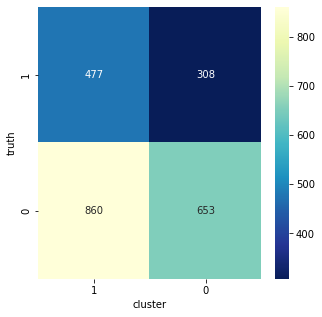

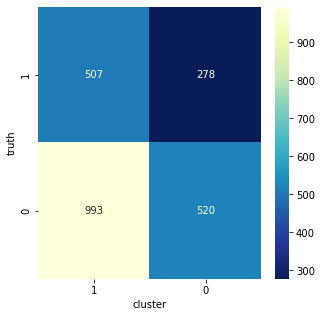

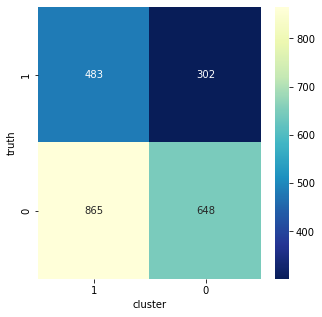

silhouette_score
0.47069253282549295
0.41367371783432094
0.4735626448284879


In [29]:
print("adjusted_rand_score")
print(metrics.adjusted_rand_score(label,kmeans0.labels_))
print(metrics.adjusted_rand_score(label,kmeans1.labels_))
print(metrics.adjusted_rand_score(label,kmeans2.labels_))
show_heatmap(metrics.confusion_matrix(label,kmeans0.labels_),col_names=['1','0'])
show_heatmap(metrics.confusion_matrix(label,kmeans1.labels_),col_names=['1','0'])
show_heatmap(metrics.confusion_matrix(label,kmeans2.labels_),col_names=['1','0'])

print("silhouette_score")
print(metrics.silhouette_score(X_2d,kmeans0.labels_))
print(metrics.silhouette_score(ECFP4_2d,kmeans1.labels_))
print(metrics.silhouette_score(phychem_2d,kmeans2.labels_))

根据silhouette_score选定phychem为新的用于预分类的属性集。

## 模型的实现

In [11]:
class My_up_sampler():
    def __init__(self):
        pass
    
    def up_sample(self,X_train,y_train):
        index_1 = y_train[y_train == 1].index
        index_0 = y_train[y_train == 0].index
        X_train_0 = X_train.loc[index_0]
        y_train_0 = y_train.loc[index_0]
        scale = len(index_1)/len(index_0)
        # print('scale:',scale)
        ret_X = copy.deepcopy(X_train)
        ret_y = copy.deepcopy(y_train)
        for i in range(math.ceil(scale)-1):
            ret_X = ret_X.append(X_train_0)
            ret_y = ret_y.append(y_train_0)
        return ret_X,ret_y  


In [12]:
class My_vote_select_with_up_sample_clf():
    def __init__(self, topN,score = 'recall',offset = 0):
        #使用phychem进行训练的基分类器
        #KNN不支持特征选择
        ExtraTree_phychem = ExtraTreeClassifier()
        RandomForest_phychem = RandomForestClassifier()
        XGB_phychem = xgb.XGBClassifier(verbosity=0,use_label_encoder=False)
        SVC_phychem = SVC(kernel="linear")
        # KNN_phychem = KNeighborsClassifier()
        #使用ECFP4_phychem进行训练的基分类器
        RandomForest_ECFP4_phychem = RandomForestClassifier()
        ExtraTree_ECFP4_phychem = ExtraTreeClassifier()
        XGB_ECFP4_phychem = xgb.XGBClassifier(verbosity=0,use_label_encoder=False)
        SVC_ECFP4_phychem = SVC(kernel="linear")
        # KNN_ECFP4_phychem = KNeighborsClassifier()
        #使用ECFP4进行训练的基分类器
        RandomForest_ECFP4 = RandomForestClassifier()
        XGB_ECFP4 = xgb.XGBClassifier(verbosity=0,use_label_encoder=False)
        SVC_ECFP4 = SVC(kernel="linear")
        LinearSVC_ECFP4 = LinearSVC()
        # KNN_ECFP4 = KNeighborsClassifier()
        
        self.base_als_phychem = [ExtraTree_phychem,RandomForest_phychem,XGB_phychem,SVC_phychem]
        self.base_als_ECFP4_phychem = [RandomForest_ECFP4_phychem,ExtraTree_ECFP4_phychem,XGB_ECFP4_phychem,SVC_ECFP4_phychem]
        self.base_als_ECFP4 = [RandomForest_ECFP4,XGB_ECFP4,SVC_ECFP4,LinearSVC_ECFP4]
        self.all_base_algo = self.base_als_phychem+self.base_als_ECFP4_phychem+self.base_als_ECFP4
        self.algo_names = ['ExtraTree_phychem','RandomForest_phychem','XGB_phychem','SVC_phychem',
        'RandomForest_ECFP4_phychem','ExtraTree_ECFP4_phychem','XGB_ECFP4_phychem','SVC_ECFP4_phychem',
        'RandomForest_ECFP4','XGB_ECFP4','SVC_ECFP4','LinearSVC_ECFP4']
        selectors = []
        for algo in self.all_base_algo:
            selectors.append(SelectFromModel(estimator = algo))
        self.algo_selector_set = list(zip(self.all_base_algo,selectors,self.algo_names))

        self.res_dic = dict()
        self.keys = ['accuracy','f1_score','auc','recall_0','recall_1','precision_0','precision_1']

        self.kmeans = KMeans(n_clusters=2)
        # self.prepredictor = My_pre_clus()
        self.topN = topN
        self.score = score
        self.offset = offset

    def res_map(self,x):
        thres = int(self.topN/2)+self.offset
        # print(thres)
        if x<=thres:
            return 0
        else:
            return 1
        
    def fit(self,X_train,y_train):
        my_up_sampler = My_up_sampler()
        # print('X_train.shape',X_train.shape)
        # print('y_train.shape',y_train.shape)
        X,y = my_up_sampler.up_sample(X_train,y_train)
        # print(X.shape)
        # print(y.shape)
        phychem = X.iloc[:,0:200]
        ECFP4 = X.iloc[:,200:-1]
        ECFP4_phychem = pd.concat([ECFP4,phychem],axis=1)

        for key in self.keys:
            self.res_dic[key] = []

        for i in range(len(self.algo_selector_set)):
            t=self.algo_selector_set[i]
            # print('fitting:',t[2])
            if i in range(4):
                t[1].fit(phychem,y)
                train_selected = t[1].transform(phychem)
            elif i in range(4,8):
                t[1].fit(ECFP4_phychem,y)
                train_selected = t[1].transform(ECFP4_phychem)
            else:
                t[1].fit(ECFP4,y)
                train_selected = t[1].transform(ECFP4)
            
            train_selected = pd.DataFrame(train_selected)
            temp_res = my_cross_validate_score(t[0],train_selected,y,cv=10,mean=True)
            for key in self.keys:
                self.res_dic[key].append(temp_res[key])

        self.kmeans.fit(phychem)
        # self.prepredictor.fit(X_train,y_train)

        # print(self.res_dic)
    def predict(self,X_test):
        phychem = X_test.iloc[:,0:200]
        ECFP4 = X_test.iloc[:,200:-1]
        ECFP4_phychem = pd.concat([ECFP4,phychem],axis=1)
        
        if self.score in ['recall','precision']:
            clf41_index = pd.DataFrame(self.res_dic).sort_values([self.score+'_1'],ascending=False)[:self.topN].index
            clf40_index = pd.DataFrame(self.res_dic).sort_values([self.score+'_0'],ascending=False)[:self.topN].index
        else:
            clf41_index = pd.DataFrame(self.res_dic).sort_values([self.score],ascending=False)[:self.topN].index
            clf40_index = pd.DataFrame(self.res_dic).sort_values([self.score],ascending=False)[:self.topN].index 


        clf41 = []
        clf40 = []
        for i,j in zip(clf41_index,clf40_index):
            clf41.append(copy.deepcopy(self.algo_selector_set[i]))
            clf40.append(copy.deepcopy(self.algo_selector_set[j]))
        
        prepred = self.kmeans.predict(phychem)
        # prepred = self.prepredictor.predict(X_test)
        clf41_preds = []
        clf40_preds = []

        for i in range(len(clf41)):
            t = clf41[i]
            if clf41_index[i] in range(0,4):
                test_data = phychem
            elif clf41_index[i] in range(4,8):
                test_data = ECFP4_phychem
            else:
                test_data = ECFP4
            clf41_preds.append(t[0].predict(t[1].transform(test_data)))

        for i in range(len(clf40)):
            t = clf40[i]
            if clf40_index[i] in range(0,4):
                test_data = phychem
            elif clf40_index[i] in range(4,8):
                test_data = ECFP4_phychem
            else:
                test_data = ECFP4
            clf40_preds.append(t[0].predict(t[1].transform(test_data)))

        # col_names = ['clf0','clf1','clf2','clf3','clf4']
        clf41_preds_dic = dict()
        clf40_preds_dic = dict()
        
        for i  in range(self.topN):
            key = 'clf'+str(i)
            clf41_preds_dic[key] = clf41_preds[i]
            clf40_preds_dic[key] = clf40_preds[i]
        
        clf41_preds_df = pd.DataFrame(clf41_preds_dic)
        clf40_preds_df = pd.DataFrame(clf40_preds_dic)

        clf41_voted_pred = clf41_preds_df.sum(axis=1).map(self.res_map)
        clf40_voted_pred = clf40_preds_df.sum(axis=1).map(self.res_map)
        
        res = []

        for i in range(len(prepred)):
            if prepred[i] == 1:
                res.append(clf41_voted_pred[i])
            else:
                res.append(clf40_voted_pred[i])

        # print('prepred',prepred)
        # print('clf41',clf41)
        # print('clf40',clf40)
        # print('clf41_preds_dic',clf41_preds_dic)
        # print('clf40_preds_dic',clf40_preds_dic)
        # print('clf41_voted_pred',clf41_voted_pred)
        # print('clf40_voted_pred',clf40_voted_pred)
        return res        

In [ ]:
my_cross_validate_score(My_vote_select_with_up_sample_clf(1,'recall'),X,label,cv = 10,mean=True)

In [ ]:
scores = ['accuracy','precision','recall','f1_score']
topNs = range(1,6,2)
reports = []

for score in scores :
    for topN in topNs:
        reports.append("{}-{}".format(score,topN))
        my_vote_clf = My_vote_select_with_up_sample_clf(topN,score=score)
        report = my_cross_validate_score(my_vote_clf,X,label,cv = 5,mean=True)
        #reports.append(metrics.classification_report(y_test,my_vote_clf_pred))
        reports.append(report)
        print("Done {}-{}".format(score,topN))
for report in reports:
    print(report)

In [13]:
class My_select_with_up_sample_clf():
    def __init__(self, topN,score = 'recall',offset = 0):
        #使用phychem进行训练的基分类器
        #KNN不支持特征选择
        ExtraTree_phychem = ExtraTreeClassifier()
        RandomForest_phychem = RandomForestClassifier()
        XGB_phychem = xgb.XGBClassifier(verbosity=0,use_label_encoder=False)
        SVC_phychem = SVC(kernel="linear")
        # KNN_phychem = KNeighborsClassifier()
        #使用ECFP4_phychem进行训练的基分类器
        RandomForest_ECFP4_phychem = RandomForestClassifier()
        ExtraTree_ECFP4_phychem = ExtraTreeClassifier()
        XGB_ECFP4_phychem = xgb.XGBClassifier(verbosity=0,use_label_encoder=False)
        SVC_ECFP4_phychem = SVC(kernel="linear")
        # KNN_ECFP4_phychem = KNeighborsClassifier()
        #使用ECFP4进行训练的基分类器
        RandomForest_ECFP4 = RandomForestClassifier()
        XGB_ECFP4 = xgb.XGBClassifier(verbosity=0,use_label_encoder=False)
        SVC_ECFP4 = SVC(kernel="linear")
        LinearSVC_ECFP4 = LinearSVC()
        # KNN_ECFP4 = KNeighborsClassifier()
        
        self.base_als_phychem = [ExtraTree_phychem,RandomForest_phychem,XGB_phychem,SVC_phychem]
        self.base_als_ECFP4_phychem = [RandomForest_ECFP4_phychem,ExtraTree_ECFP4_phychem,XGB_ECFP4_phychem,SVC_ECFP4_phychem]
        self.base_als_ECFP4 = [RandomForest_ECFP4,XGB_ECFP4,SVC_ECFP4,LinearSVC_ECFP4]
        self.all_base_algo = self.base_als_phychem+self.base_als_ECFP4_phychem+self.base_als_ECFP4
        self.algo_names = ['ExtraTree_phychem','RandomForest_phychem','XGB_phychem','SVC_phychem',
        'RandomForest_ECFP4_phychem','ExtraTree_ECFP4_phychem','XGB_ECFP4_phychem','SVC_ECFP4_phychem',
        'RandomForest_ECFP4','XGB_ECFP4','SVC_ECFP4','LinearSVC_ECFP4']
        selectors = []
        for algo in self.all_base_algo:
            selectors.append(SelectFromModel(estimator = algo))
        self.algo_selector_set = list(zip(self.all_base_algo,selectors,self.algo_names))

        self.res_dic = dict()
        self.keys = ['accuracy','f1_score','auc','recall_0','recall_1','precision_0','precision_1']

        self.kmeans = KMeans(n_clusters=2)
        # self.prepredictor = My_pre_clus()
        self.topN = topN
        self.score = score
        self.offset = offset

    def res_map(self,x):
        thres = int(self.topN/2)+self.offset
        # print(thres)
        if x<=thres:
            return 0
        else:
            return 1
        
    def fit(self,X_train,y_train):
        my_up_sampler = My_up_sampler()
        # print('X_train.shape',X_train.shape)
        # print('y_train.shape',y_train.shape)
        X,y = my_up_sampler.up_sample(X_train,y_train)
        # print(X.shape)
        # print(y.shape)
        phychem = X.iloc[:,0:200]
        ECFP4 = X.iloc[:,200:-1]
        ECFP4_phychem = pd.concat([ECFP4,phychem],axis=1)

        for key in self.keys:
            self.res_dic[key] = []

        for i in range(len(self.algo_selector_set)):
            t=self.algo_selector_set[i]
            # print('fitting:',t[2])
            if i in range(4):
                t[1].fit(phychem,y)
                train_selected = t[1].transform(phychem)
            elif i in range(4,8):
                t[1].fit(ECFP4_phychem,y)
                train_selected = t[1].transform(ECFP4_phychem)
            else:
                t[1].fit(ECFP4,y)
                train_selected = t[1].transform(ECFP4)
            
            train_selected = pd.DataFrame(train_selected)
            temp_res = my_cross_validate_score(t[0],train_selected,y,cv=10,mean=True)
            for key in self.keys:
                self.res_dic[key].append(temp_res[key])

        self.kmeans.fit(phychem)
        # self.prepredictor.fit(X_train,y_train)

        # print(self.res_dic)
    def predict(self,X_test):
        phychem = X_test.iloc[:,0:200]
        ECFP4 = X_test.iloc[:,200:-1]
        ECFP4_phychem = pd.concat([ECFP4,phychem],axis=1)
        
        if self.score in ['recall','precision']:
            clf40_index = pd.DataFrame(self.res_dic).sort_values([self.score+'_0'],ascending=False)[:self.topN].index
        else:
            clf40_index = pd.DataFrame(self.res_dic).sort_values([self.score],ascending=False)[:self.topN].index 


        clf40 = []
        for i in clf40_index:
            clf40.append(copy.deepcopy(self.algo_selector_set[i]))
        
        clf40_preds = []

        for i in range(len(clf40)):
            t = clf40[i]
            if clf40_index[i] in range(0,4):
                test_data = phychem
            elif clf40_index[i] in range(4,8):
                test_data = ECFP4_phychem
            else:
                test_data = ECFP4
            clf40_preds.append(t[0].predict(t[1].transform(test_data)))

        clf40_preds_dic = dict()
        
        for i  in range(self.topN):
            key = 'clf'+str(i)
            clf40_preds_dic[key] = clf40_preds[i]
        
        clf40_preds_df = pd.DataFrame(clf40_preds_dic)

        clf40_voted_pred = clf40_preds_df.sum(axis=1).map(self.res_map)
        
        res = clf40_voted_pred


        # print('prepred',prepred)
        # print('clf41',clf41)
        # print('clf40',clf40)
        # print('clf41_preds_dic',clf41_preds_dic)
        # print('clf40_preds_dic',clf40_preds_dic)
        # print('clf41_voted_pred',clf41_voted_pred)
        # print('clf40_voted_pred',clf40_voted_pred)
        return res        

In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,label,test_size = 0.1)
X_test.head()

,rdkit_1,rdkit_2,rdkit_3,rdkit_4,rdkit_5,rdkit_6,rdkit_7,rdkit_8,rdkit_9,rdkit_10,...,ECFP4_2039,ECFP4_2040,ECFP4_2041,ECFP4_2042,ECFP4_2043,ECFP4_2044,ECFP4_2045,ECFP4_2046,ECFP4_2047,ECFP4_2048
1144,0.399844,0.952563,0.952699,0.939984,0.933212,0.932224,0.905238,0.875947,0.923629,0.891987,...,0,0,0,0,0,0,0,0,0,0
605,0.462659,0.365173,0.510084,0.412966,0.435242,0.446535,0.383351,0.585698,0.442842,0.701950,...,0,0,0,0,0,0,0,0,0,0
511,0.488657,0.053797,0.106451,0.159206,0.122831,0.109068,0.224011,0.164605,0.272751,0.186086,...,0,0,0,0,0,0,0,1,0,0
2231,0.567060,0.353890,0.460198,0.360123,0.381730,0.389016,0.324908,0.375442,0.462502,0.645935,...,0,0,0,0,0,0,0,0,0,0
1536,0.951387,0.010364,0.003183,0.002725,0.001712,0.003756,0.004091,0.002999,0.004473,0.002046,...,0,0,0,0,0,0,0,0,0,0


In [15]:
scores = ['accuracy','precision','recall','f1_score']
topNs = range(1,6,2)
reports = []
for score in scores :
    for topN in topNs:
        reports.append("{}-{}".format(score,topN))
        my_vote_clf = My_select_with_up_sample_clf(topN,score=score)
        my_vote_clf.fit(X_train,y_train)
        my_vote_clf_pred =  my_vote_clf.predict(X_test)
        reports.append(metrics.classification_report(y_test,my_vote_clf_pred))
        print("Done {}-{}".format(score,topN))
for report in reports:
    print(report)

e:\anaconda\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done accuracy-1


e:\anaconda\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done accuracy-3


e:\anaconda\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done accuracy-5


e:\anaconda\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done precision-1


e:\anaconda\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
e:\anaconda\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done precision-3


e:\anaconda\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done precision-5


e:\anaconda\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done recall-1


e:\anaconda\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done recall-3


e:\anaconda\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done recall-5


e:\anaconda\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done f1_score-1


e:\anaconda\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done f1_score-3


e:\anaconda\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done f1_score-5
accuracy-1
              precision    recall  f1-score   support

           0       0.40      0.39      0.39        77
           1       0.70      0.71      0.70       153

    accuracy                           0.60       230
   macro avg       0.55      0.55      0.55       230
weighted avg       0.60      0.60      0.60       230

accuracy-3
              precision    recall  f1-score   support

           0       0.45      0.43      0.44        77
           1       0.72      0.73      0.72       153

    accuracy                           0.63       230
   macro avg       0.58      0.58      0.58       230
weighted avg       0.63      0.63      0.63       230

accuracy-5
              precision    recall  f1-score   support

           0       0.54      0.52      0.53        77
           1       0.76      0.78      0.77       153

    accuracy                           0.69       230
   macro avg       0.65      0.65      0.65       230
weighted avg       0.69  